In [1]:
#!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install torch-geometric

# link prediction


In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from modules.model import Net
import random
from datetime import datetime
from sklearn.metrics import roc_auc_score

import optuna
from modules.negativeSampling import NegativeSampler
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP

In [12]:
import pickle
import os

class Main():
    def __init__(self,conv, device, loss_function, mode = 'unsupervised',**kwargs):
        self.dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
        data = self.dataset[0]
        self.Conv = conv
        self.device = device
        self.x = data.x
        self.y = data.y.squeeze()
        self.data=data.to(device)
        self.dataprocess(data)
        self.loss = loss_function
        self.mode = mode
        self.train_mask = torch.tensor([True]*int(0.8*len(data.x)+1) + [False]*int(0.2*len(data.x)))
        #val_mask = torch.tensor([False]*int(0.6*len(data.x)+1) + [True]*int(0.2*len(data.x)+1)+[False]*int(0.2*len(data.x)))
        self.test_mask = torch.tensor([False]*int(0.8*len(data.x)+1) + [True]*int(0.2*len(data.x)))
        self.flag = self.loss["flag"]
        
        super(Main, self).__init__()
    def dataprocess(self,data):
        #splitting data to train and test
        train_edge_index = []
        test_edge_index = []
        indices_to_delete_for_test  = random.choices(list(range(len(data.edge_index[0]))), k = int(len(data.edge_index[0])*0.1))
        indices_to_delete_for_val  = random.choices(list(range(len(data.edge_index[0]))), k = int(len(data.edge_index[0])*0.1))
        
        for i,x in enumerate(list(zip(*data.edge_index.tolist()))):
            if i in indices_to_delete:
                test_edge_index.append(x)
            else:
                train_edge_index.append(x)
        val_edge_index = torch.tensor(np.array(list(zip(*val_edge_index))))
        test_edge_index = torch.tensor(np.array(list(zip(*test_edge_index))))
        train_edge_index = torch.tensor(np.array(list(zip(*train_edge_index))), dtype = torch.long)
        #data.edge_index = train_edge_index 
        s=set()
        for i in range(len(data.x)):
            for j in range(len(data.x)):
                s.add((i,j) )
                s_of_edges = set()
        for pair in (data.edge_index.t().tolist()):
            s_of_edges.add(tuple(pair))
        s_of_non_edges = s - s_of_edges
        #append negative samples to test set
        non_edges=[]
        for pair in list(s_of_non_edges):
            non_edges.append(list(pair))
        self.non_edges_to_train=torch.tensor(random.choices(non_edges, k = len(test_edge_index[0]))).t()
        self.y_true = [1]*len(test_edge_index[0])
        self.test_edge_index=torch.cat((test_edge_index,self.non_edges_to_train),1)
        self.y_true += [0]*len(self.non_edges_to_train[0])
        self.data.edge_index = train_edge_index
    
    def sampling(self,Sampler,epoch,nodes):
        if (epoch == 0): 
            if self.flag:  
                if "alpha" in self.loss: 
                    name_of_file = "samples_"+self.loss["Name"]+"_alpha_"+str(self.loss["alpha"])+".pickle"
                else:
                    name_of_file = "samples_"+self.loss["Name"]+".pickle"
                
                if os.path.exists(name_of_file):
                    with open(name_of_file,'rb') as f:
                        self.samples = pickle.load(f)
                else:
                    self.samples = Sampler.sample(nodes) 
                    with open(name_of_file,'wb') as f:
                        self.samples = pickle.dump(self.samples,f)
            else:
                
                self.samples = Sampler.sample(nodes)
        return self.samples
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr=torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                out = model.inference(data.to(device),dp=dropout)
                samples = self.sampling(Sampler,epoch, indices_of_train_data)
                loss = model.loss(out[self.train_mask], self.samples)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(device)].to(device), adjs)
                    samples = self.sampling(Sampler,epoch,n_id[:batch_size])                 
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
            return total_loss /len(train_loader)
        elif model.mode== 'supervised':
            if model.conv=='GCN':
                out = model.inference(data.to(device),dp=dropout)
                loss = model.loss_sup(out[self.train_mask],y[self.train_mask])
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    adjs = [adj for adj in adjs]
                    out = model.forward(data.x[n_id].to(device), adjs)
                    loss = model.loss_sup(out,y[n_id[:batch_size]])
                    total_loss+=loss
            total_loss.backward(retain_graph=True)
            optimizer.step()      
            return total_loss /len(train_loader)       

    @torch.no_grad()
    def test_lp(self,model,data,classifier): 
        model.eval()
        out = model.inference(data.to(device))
        y_true = np.array(self.y_true)
        if model.mode == 'supervised':
            y_true = y.cpu().unsqueeze(-1)
            y_pred = out.cpu().argmax(dim=-1, keepdim=True)
            accs = []

            accs=[int(y_pred.eq(y_true[mas]).sum()) / int(mask.sum())]
            return accs

        elif model.mode == 'unsupervised':
            y_pred = []
            for x in list(zip(*self.test_edge_index)):
                y_pred.append(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
            return roc_auc_score(y_true,np.array(y_pred)) 
            #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]

    def run(self,**kwargs):
        
        hidden_layer = 64
        out_layer = 128
        dropout = 0.3
        size = 1
        learning_rate = 0.00685

        classifier = "logistic regression"
        train_loader = 3 #NeighborSampler(self.data.edge_index, node_idx=self.train_mask, batch_size = int(sum(self.train_mask)), sizes=[-1]*size)
        Sampler=self.loss["Sampler"]
        LossSampler = Sampler(self.data,device=device,mask=self.train_mask,loss_info=self.loss)
        model = Net(dataset = self.dataset,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.1)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+self.loss["Name"]

        print(name_of_plot)

        for epoch in range(50):
                    print('epoch',epoch)
                    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch)
                    losses.append(loss)
                    d_test = datetime.now()
                    test_acc = self.test_lp(model,self.data,'logistic regression')
                    test_accs.append(test_acc)
                    log = 'Loss: {:.4f}, Epoch: {:03d}, Test: {:.4f}'
                    #scheduler.step()
                    print(log.format(loss, epoch, test_acc))
        print('Test acc on the last epoch ', test_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
                    #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]

In [13]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])

        # варьируем параметры
        loss_to_train={}
        for name in self.loss:
            
            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.dataset,mode='unsupervised',conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)

        train_loader = NeighborSampler(self.data.edge_index, batch_size =int(sum(self.train_mask)),node_idx=self.train_mask, sizes=[-1]*size)
        
        #train_loader = GraphSAINTRandomWalkSampler(data, batch_size=2176, walk_length=2,num_steps=5, sample_coverage=100,save_dir=dataset.processed_dir,num_workers=4)

        LossSampler = Sampler(self.data,device=self.device,mask=self.train_mask,loss_info=loss_to_train)

        model.to(device)

        learning_rate= trial.suggest_float("lr",5e-4,1e-2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        classifier = "logistic regression" #trial.suggest_categorical("classifier", ["logistic regression", "catboost"])

        if classifier == "catboost":
            n_estimators = trial.suggest_int("n of estimators", 10,40,5)
            learning_rate_catboost = trial.suggest_float("lr_catboost",5e-4,1e-2)
            max_depth = trial.suggest_int("max_depth",1,10,2)
        else:
            n_estimators = -1
            learning_rate_catboost =-1
            max_depth = -1
        #training of the model
        for epoch in range(50):
            loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch)
            #print(loss)

        test_acc = self.test_lp(model,self.data,classifier)


        trial.report(test_acc,epoch)

        return test_acc

    
    def run(self,number_of_trials):

        study = optuna.create_study(direction="maximize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)

        print('Best trial:')
        trial = study.best_trial
        print(" Value: ", trial.value)
        print(" Params: ")
        for key, value in trial.params.items():
            print(" {}: {}".format(key,value))
    

In [ ]:
 #SAGE = {"Name":"SAGE" , "walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":20,"context size" : [5,20,5],"p":1,"q":1, "loss var": "Random Walks","flag":False,"Sampler" =SamplerRandomWalk }
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
DeepWalk = {"Name": "DeepWalk","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p": [0.0,0.9] ,"q":[0.0,0.9], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое 

LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler" :SamplerContextMatrix} 
HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":True,"alpha": [0,1],"Sampler" :SamplerFactorization} #проверить
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0,1],"Sampler" :SamplerFactorization,} #проверить
HOPE_CN = {"Name": "HOPE_CommonNeighbors","C":"CN","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 

LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization}
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization} 

VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix}
VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler":SamplerContextMatrix} 
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"Sampler" :SamplerContextMatrix} 

APP ={"Name": "APP","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}

Struc2Vec ={} #Implement

conv: GCN, mode: unsupervised, loss from APP
epoch 0
Loss: 5.4423, Epoch: 000, Test: 0.8299
epoch 1
Loss: 2.6299, Epoch: 001, Test: 0.7851
epoch 2
Loss: 1.6503, Epoch: 002, Test: 0.7719
epoch 3
Loss: 1.4792, Epoch: 003, Test: 0.7663
epoch 4
Loss: 1.4194, Epoch: 004, Test: 0.7635
epoch 5
Loss: 1.3948, Epoch: 005, Test: 0.7618
epoch 6
Loss: 1.3905, Epoch: 006, Test: 0.7607
epoch 7
Loss: 1.3994, Epoch: 007, Test: 0.7601
epoch 8
Loss: 1.4168, Epoch: 008, Test: 0.7596
epoch 9
Loss: 1.4390, Epoch: 009, Test: 0.7593
epoch 10
Loss: 1.4631, Epoch: 010, Test: 0.7592
epoch 11
Loss: 1.4868, Epoch: 011, Test: 0.7591
epoch 12
Loss: 1.5084, Epoch: 012, Test: 0.7592
epoch 13
Loss: 1.5266, Epoch: 013, Test: 0.7594
epoch 14
Loss: 1.5407, Epoch: 014, Test: 0.7596
epoch 15
Loss: 1.5502, Epoch: 015, Test: 0.7600
epoch 16
Loss: 1.5551, Epoch: 016, Test: 0.7603
epoch 17
Loss: 1.5556, Epoch: 017, Test: 0.7606
epoch 18
Loss: 1.5519, Epoch: 018, Test: 0.7610
epoch 19
Loss: 1.5448, Epoch: 019, Test: 0.7614
epoch

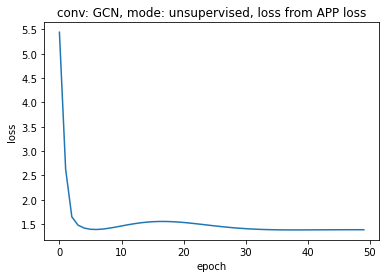

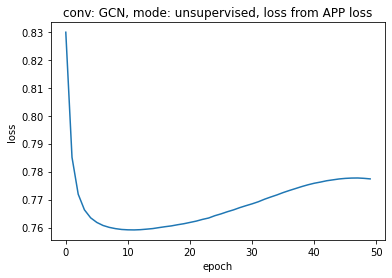

In [15]:
device =  torch.device('cpu')# if torch.cuda.is_available() else 'cpu')

APP ={"Name": "APP","C": "PPR","num_negative_samples":6,"loss var": "Context Matrix","flag":True,"alpha":0.8 ,"Sampler" :SamplerAPP}
loss = APP
MO = Main('GCN', device, loss , mode = 'unsupervised')
MO.run()

In [9]:
device =  torch.device('cpu')# if torch.cuda.is_available() else 'cpu')
loss = APP
MO = MainOptuna('GCN', device, loss , mode = 'unsupervised')
MO.run(number_of_trials=10)


[I 2021-04-23 17:53:24,039] A new study created in memory with name: APP loss,GCN conv
[I 2021-04-23 17:53:39,025] Trial 0 finished with value: 0.7879110597590343 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.30000000000000004, 'size of network, number of convs': 1, 'num_negative_samples': 6, 'alpha': 0.8, 'lr': 0.006850436452683323}. Best is trial 0 with value: 0.7879110597590343.
[I 2021-04-23 17:53:52,400] Trial 1 finished with value: 0.7545341549665628 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 3, 'num_negative_samples': 11, 'alpha': 0.7, 'lr': 0.0031263523414701783}. Best is trial 0 with value: 0.7879110597590343.
[I 2021-04-23 17:55:05,999] Trial 2 finished with value: 0.7459414352905478 and parameters: {'hidden_layer': 256, 'out_layer': 128, 'dropout': 0.5, 'size of network, number of convs': 3, 'num_negative_samples': 21, 'alpha': 0.1, 'lr': 0.0010838845296519978}. Best is trial 0 with value: 0

Best trial:
 Value:  0.7879110597590343
 Params: 
 hidden_layer: 64
 out_layer: 128
 dropout: 0.30000000000000004
 size of network, number of convs: 1
 num_negative_samples: 6
 alpha: 0.8
 lr: 0.006850436452683323


In [10]:
from sklearn.metrics import precision_score, roc_auc_score

def train_lp(model,data,optimizer,Sampler,train_loader,dropout,epoch):
    model.train()        
    total_loss = 0
    optimizer.zero_grad()
    if model.mode == 'unsupervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device),dp=dropout)
            if epoch == 0:
                samples = Sampler.sample(torch.tensor(list(range(len(data.x)))))
            loss = model.loss(out, samples)
            total_loss+=loss
        else:
            for batch_size, n_id, adjs in train_loader:
                # adjs holds a list of (edge_index, e_id, size) tuples.
                if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                if epoch == 0:
                    samples = Sampler.sample((n_id.numpy().tolist())[:batch_size])
                loss = model.loss(out, samples)#pos_batch.to(device), neg_batch.to(device))
                #print(out.shape, samples[0].shape,samples[1].shape)
                total_loss+=loss
        total_loss.backward()
        optimizer.step()      
        return total_loss# /len(train_loader)
    elif model.mode== 'supervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device),dp=dropout)
            loss = model.loss_sup(out[train_mask],y[train_mask])
            total_loss+=loss 
        else:
            for batch_size, n_id, adjs in train_loader:
                if len(train_loader.sizes) == 1:
                        adjs = [adjs]    
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                loss = model.loss_sup(out,y[n_id[:batch_size]])
                total_loss+=loss
        total_loss.backward(retain_graph=True)
        optimizer.step()      
        return total_loss# /len(train_loader)       

@torch.no_grad()
def test_lp(model,data,classifier,y_true): 
    model.eval()
    out = model.inference(data.to(device))
    y_true = np.array(y_true)
    if model.mode == 'supervised':
        y_true = y.cpu().unsqueeze(-1)
        y_pred = out.cpu().argmax(dim=-1, keepdim=True)
        accs = []
        
        accs=[int(y_pred.eq(y_true[mas]).sum()) / int(mask.sum())]
        return accs
    
    elif model.mode == 'unsupervised':
        y_pred = []
        for x in list(zip(*test_edge_index)):
            y_pred.append(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))

        return roc_auc_score(y_true,np.array(y_pred)) 
        #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]

In [11]:
#models = [Net(dataset = dataset,mode='supervised',conv='GCN',device=device), Net(dataset = dataset,mode='supervised',conv='GAT',device=device),Net(dataset = dataset,mode='supervised',conv='SGC',device=device), Net(dataset = dataset,mode='unsupervised',conv='GCN',device=device),Net(dataset = dataset,mode='unsupervised',conv='GAT',device=device),Net(dataset = dataset,mode='unsupervised',conv='SAGE',device=device)]

sizes = [-1]

hidden_layer = 64
out_layer = 128
dropout = 0.5
size = [10,25]
learning_rate = 0.003

classifier = "logistic regression"
loss=APP
from datetime import datetime
d = datetime.now()
train_mask = torch.tensor([True]*len(data.x))
if True:
        hidden_layer = 64
        out_layer = 128
        dropout = 0.4
        size = 1
        learning_rate = 0.001
        Conv = "GAT"
        loss = APP
        device = torch.device('cuda')
        classifier = "logistic regression"
        train_loader = NeighborSampler(data.edge_index, node_idx = train_mask, batch_size = len(data.x), sizes=[-1]*size)
        Sampler = loss["Sampler"]
        LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
        model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.1)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+loss["Name"]

        print(name_of_plot)

        for epoch in range(50):
                    print('epoch',epoch)
                    loss = train_lp(model,data,optimizer,LossSampler,train_loader,dropout,epoch)
                    losses.append(loss)
                    d_test = datetime.now()
                    test_acc = test_lp(model,data,'logistic regression',y_true)
                   # print('тестирование заняло: ', datetime.now()-d_test)
                    test_accs.append(test_acc)
                   # val_accs.append(val_acc)
                    log = 'Loss: {:.4f}, Epoch: {:03d}, Test: {:.4f}'
                    #scheduler.step()
                    print(log.format(loss, epoch, test_acc))
        print('Test acc on the last epoch ', test_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

conv: GAT, mode: unsupervised, loss from APP
epoch 0


TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [ ]:
test_acc = test_lp(model,data,'logistic regression',y_true)
print('Test acc on the last epoch ', test_acc)

# optuna

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [5]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,20,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    #classifier = "logistic regression"
    classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [5]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,20,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    classifier = "logistic regression"
    #classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer =32# trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [10]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,20,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    #classifier = "logistic regression"
    classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer =32# trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [10]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,10,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    classifier = "logistic regression"
    #classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [25]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,10,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    #classifier = "logistic regression"
    classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
import optuna
from torch_geometric.datasets import Planetoid
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

def objective(trial):
    # Integer parameter
    hidden_layer = 32#trial.suggest_categorical("hidden_layer", [32,64,128,256])
    out_layer = trial.suggest_int("out_layer", 32,128,step = 32,log = False)
    # Floating point parameter
    dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
   # size_str = trial.suggest_categorical("size", ["[10]","[25]","[5,10]","[10,25]","[5,10,25]"])
   # b = size_str.split("[")[1].split("]")[0].split(',')
    size = [25]#list(map(lambda x: int(x),b))

    Conv ="GAT"# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])
    
    walk_length = trial.suggest_int("walk length",5,20,step = 5)
    walks_per_node = trial.suggest_int("walks per node", 5,10,step = 5)
    context_size = trial.suggest_int("context size",5,20,step = 5)
    num_negative_samples = walks_per_node
    loss = {"Name":"SAGE" , "walk length":walk_length,"walks per node":walks_per_node,"num negative samples":num_negative_samples,"context size" : context_size,"p":1,"q":1, "loss var": "Random Walks"}

    model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = len(size),dropout = dropout)
    train_loader = NeighborSampler(data.edge_index, node_idx=train_mask, batch_size = 677, sizes=size)
    LossSampler = Sampler(data,device=device,mask=train_mask,loss_info=loss)
    
    model.to(device)
    #Generate the optimizers
#optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    learning_rate=trial.suggest_float("lr",5e-4,1e-2)
    #optimizer = getattr(optim,optimizer_name)(model.parameters(),lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  
    #classifier = trial.suggest_categorical("classifier", ["logistic regression", "catboost"])
    classifier = "logistic regression"
    #classifier = "catboost"
    #training of the model
    for epoch in range(50):
        loss = train(model,data,optimizer,LossSampler,train_loader,dropout)
        train_acc, test_acc = test(model,data,classifier)
        
    trial.report(test_acc,epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialsPruned()
    return test_acc
        
    
study = optuna.create_study(direction="maximize",study_name="SAGE loss")
study.optimize(objective,n_trials = 3)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finid=shed trials: ",len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))